In [1]:
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
from agents.utils import OUNoise

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=False)[brain_name]
num_agents = len(env_info.agents)
states = env_info.vector_observations
action_size = brain.vector_action_space_size
state_size = states.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## Analysis
The agents should be the same given the symmetrical property of the environment. Therefore, the policy of an agent trained on the left should be valid when we put the same agent at the right. However, its input would need to be twicked. The first step would consist then to validate that the observations are already symmetrical or not. **That should reduce the training time by half**.

Here are the assumptions:
* The observation state of each agent is having a length of 24
* The observation state contains values about:
    * The position and velocity of the ball
    * The position and velocity of the agent
    * The position and velocity of the opponent
* The horizontal component of the state could be multiplied by -1 to flip the board symmetrically to a vertical axis:
    * horizontal position and velocity of the ball
    * horizontal position and velocity of the agent
    * horizontal position and velocity of the opponent

### Analysis of the different components of the observations and actions
To find the relation between the observed states, let us sent one action to both agents and print the states observed by the agents at each time steps

In [3]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations

for i in range(50):
    actions = np.array([[0.5, 0],[0.5, 0]]) # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    print("{}\tAgent 1\t{}".format(i, next_states[0]))
    print("{}\tAgent 2\t{}".format(i, next_states[1]))
    states = next_states                               # roll over states to next time step

0	Agent 1	[ 0.          0.          0.          0.          0.          0.
  0.          0.         -7.38993645 -1.5        -0.          0.
  6.83172083  5.99607611 -0.          0.         -5.88993549 -1.55886006
 15.         -0.98100001  6.83172083  5.91759634 15.         -0.98100001]
0	Agent 2	[ 0.          0.          0.          0.          0.          0.
  0.          0.         -6.70024681 -1.5         0.          0.
 -6.83172083  5.99607611  0.          0.         -5.20024586 -1.55886006
 15.         -0.98100001 -6.83172083  5.91759634 15.         -0.98100001]
1	Agent 1	[-7.38993645 -1.5        -0.          0.          6.83172083  5.99607611
 -0.          0.         -5.88993549 -1.55886006 15.         -0.98100001
  6.83172083  5.91759634 15.         -0.98100001 -4.38993454 -1.71581995
 15.         -1.96200001  6.83172083  5.74101639 15.         -1.96200001]
1	Agent 2	[-6.70024681 -1.5         0.          0.         -6.83172083  5.99607611
  0.          0.         -5.20024586 -1.

14	Agent 1	[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -7.43639946 -1.5
 -0.          0.          6.69487906  5.96076012 -0.          0.        ]
14	Agent 2	[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -7.73019552 -1.5
  0.          0.         -6.69487906  5.96076012  0.          0.        ]
15	Agent 1	[ 0.          0.          0.          0.          0.          0.
  0.          0.         -7.43639946 -1.5        -0.          0.
  6.69487906  5.96076012 -0.          0.         -5.93639851 -1.55886006
 15.         -0.98100001  6.69487906  5.82342005 15.         -0.98100001]
15	Agent 2	[ 0.          0.          0.          0.          0.          0.
  0.          0.         -7.73019552 -1.5         0.          0.
 -6.69487

29	Agent 1	[ 0.          0.          0.          0.          0.          0.
  0.          0.         -6.55063343 -1.5        -0.          0.
  6.24261761  5.98822832 -0.          0.         -5.05063248 -1.55886006
 15.         -0.98100001  6.24261761  5.89012814 15.         -0.98100001]
29	Agent 2	[ 0.          0.          0.          0.          0.          0.
  0.          0.         -6.46228027 -1.5         0.          0.
 -6.24261761  5.98822832  0.          0.         -4.96227932 -1.55886006
 15.         -0.98100001 -6.24261761  5.89012814 15.         -0.98100001]
30	Agent 1	[-6.55063343 -1.5        -0.          0.          6.24261761  5.98822832
 -0.          0.         -5.05063248 -1.55886006 15.         -0.98100001
  6.24261761  5.89012814 15.         -0.98100001 -3.550632   -1.71581995
 15.         -1.96200001  6.24261761  5.69392824 15.         -1.96200001]
30	Agent 2	[-6.46228027 -1.5         0.          0.         -6.24261761  5.98822832
  0.          0.         -4.96227932

44	Agent 1	[-7.08839989 -1.5        -0.          0.          6.59263992  6.
 -0.          0.         -5.58839893 -1.55886006 15.         -0.98100001
  6.59263992  5.94114017 15.         -0.98100001 -4.08839798 -1.71581995
 15.         -1.96200001  6.59263992  5.78418016 15.         -1.96200001]
44	Agent 2	[-7.44412899 -1.5         0.          0.         -6.59263992  6.
  0.          0.         -5.94412804 -1.55886006 15.         -0.98100001
 -6.59263992  5.94114017 15.         -0.98100001 -4.44412708 -1.71581995
 15.         -1.96200001 -6.59263992  5.78418016 15.         -1.96200001]
45	Agent 1	[-5.58839893 -1.55886006 15.         -0.98100001  6.59263992  5.94114017
 15.         -0.98100001 -4.08839798 -1.71581995 15.         -1.96200001
  6.59263992  5.78418016 15.         -1.96200001 -2.58839822 -1.85235918
 15.          0.          6.59263992  5.52912045 15.          0.        ]
45	Agent 2	[-5.94412804 -1.55886006 15.         -0.98100001 -6.59263992  5.94114017
 15.         -0.9810

According to the previous result and the observation of the rendered screen:
* the 1st element of the action is defining the "force" applied by one agent to reach the net
    * with a positive value, an agent is moving to the net
    * with a negative value, the agent is moving away from the net
* the 2nd element of the action is defining the jumping "force" and it is discrete
    * with zero, the agent stays on the ground
    * with one, the agent is jumping
* only the index 4, 12, and 20 of the states observed by the agents are symmetrical along 0

In [4]:
# reset the environment and observe the symmetrical values while moving only one agent
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations

for i in range(10):
    actions = np.array([[0.5, 0],[0, 0]])                # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    print("{}\tAgent 1\t{}\t{}\t{}".format(i, next_states[0][4], next_states[0][12], next_states[0][20]))
    print("{}\tAgent 2\t{}\t{}\t{}".format(i, next_states[1][4], next_states[1][12], next_states[1][20]))
    states = next_states                               # roll over states to next time step

0	Agent 1	0.0	6.592639923095703	6.592639923095703
0	Agent 2	0.0	-6.592639923095703	-6.592639923095703
1	Agent 1	6.592639923095703	6.592639923095703	6.592639923095703
1	Agent 2	-6.592639923095703	-6.592639923095703	-6.592639923095703
2	Agent 1	6.592639923095703	6.592639923095703	6.592639923095703
2	Agent 2	-6.592639923095703	-6.592639923095703	-6.592639923095703
3	Agent 1	6.592639923095703	6.592639923095703	6.592639923095703
3	Agent 2	-6.592639923095703	-6.592639923095703	-6.592639923095703
4	Agent 1	6.592639923095703	6.592639923095703	6.592639923095703
4	Agent 2	-6.592639923095703	-6.592639923095703	-6.592639923095703
5	Agent 1	6.592639923095703	6.592639923095703	6.270532608032227
5	Agent 2	-6.592639923095703	-6.592639923095703	-6.270532608032227
6	Agent 1	6.592639923095703	6.270532608032227	5.465264320373535
6	Agent 2	-6.592639923095703	-6.270532608032227	-5.465264320373535
7	Agent 1	6.270532608032227	5.465264320373535	4.659996032714844
7	Agent 2	-6.270532608032227	-5.465264320373535	

According to the previous result and the observation of the rendered screen:
* the 1st element of the action is defining the "force" applied by one agent to reach the net
    * with a positive value, an agent is moving to the net
    * with a negative value, the agent is moving away from the net
* the 2nd element of the action is defining the jumping "force" and it is discrete
    * with zero, the agent stays on the ground
    * with one, the agent is jumping
* only the index 4, 12, and 20 of the states observed by the agents are symmetrical along 0
* the agent of the right is the agent with index 0
* these indices 4, 12, and 20 are the x position of the ball from the point of view of the agent within 3 successive timesteps

*Conclusion*:
The observation states are describing the environment from the point of view of the agent and not of the viewer. Therefore, one unique agent can be trained by using both observations

## Training
After that confirmation, we start the training

In [5]:
def plot_result(scores):
    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [8]:
def train(agent, logger, n_episodes=500, train_mode=True):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]
        states = env_info.vector_observations
        scores_one_episode = np.zeros(2)
        trajectories_states, trajectories_next_states, trajectories_full_states, trajectories_actions, \
        trajectories_log_probs, trajectories_values, trajectories_rewards, \
        trajectories_dones = [], [], [], [], [], [], [], []
        
        while True:
            actions, log_probs = agent.act(states)
            trajectories_states.append(states)
            trajectories_actions.append(actions)
            trajectories_log_probs.append(log_probs)            
           
            # Concatenate all states and actions taken by all agents
            # from agent 0 point of view, concatenate state seen by agent 0, state seen by agent 1, action agent 0, action agent 1
            # from agent 1 point of view, concatenate state seen by agent 1, state seen by agent 0, action agent 1, action agent 0
            full_state = np.zeros((num_agents, (state_size + action_size) * num_agents))
            for i in range(num_agents):
                start = 0
                start_action = state_size * num_agents
                idx = np.arange(num_agents)
                for j in idx:
                    full_state[i][start:start + state_size] += states[j]
                    full_state[i][start_action: start_action + action_size] += actions[j]
                    start += state_size
                    start_action += action_size
                idx = np.roll(idx, -1)
                    
            trajectories_full_states.append(full_state)
            trajectories_values.append(agent.estimate(full_state).squeeze(-1))
                
            env_info = env.step(np.clip(actions, -1, 1))[brain_name]              # send all actions to the environment
            next_states = env_info.vector_observations                            # get next state (for each agent)
            rewards = env_info.rewards                                            # get reward (for each agent)
            dones = env_info.local_done                                           # see if episode finished
            scores_one_episode += rewards
                        
            trajectories_next_states.append(next_states)
            trajectories_rewards.append(rewards)
            trajectories_dones.append(dones)
                
            states = next_states                                     # roll over states to next time step
            if np.any(dones):                                        # exit loop if episode finished
                break
#                 env_info = env.reset(train_mode=train_mode)[brain_name]
#                 states = env_info.vector_observations 
        
        # in the optimization of the critic, we need the next values
        trajectories_next_values = trajectories_values.copy()
        for i in range(len(trajectories_next_values)):
            trajectories_next_values[i] = trajectories_next_values[i].copy()
                
        # ensure that the next value of timestep i is the value of timestep i+1           
        trajectories_next_values = np.roll(np.array(trajectories_next_values), -1, axis=0)
        # these values will be used in the calculation of the temporal difference during 
        # the calculation of the advantages. The formula is that if the timestep is done then
        # the temportal difference wouldn't be function of the next values
        # yet, with this gathering approach, the episode is ending when done
        # therefore, terms dones * next_values would always be zero
        # so instead of calculating the next value by producing the full states of the next states
        # we just assign zero to the last next values
        trajectories_next_values[-1]=0

        agent.learn(trajectories_states, 
            trajectories_actions, 
            trajectories_log_probs, 
            trajectories_values, 
            trajectories_rewards, 
            trajectories_next_states,
            trajectories_dones, 
            trajectories_full_states, 
            trajectories_next_values)
        
        
        logger.add_histogram("env/rewards", scores_one_episode)
        score = np.max(scores_one_episode)
        scores.append(score)
        scores_window.append(score)
        mean_100 = np.mean(scores_window)

        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}\tMax Score: {:.3f}\tLast Score: {:.3f}'.
                      format(i_episode, 
                         mean_100, 
                         np.max(scores_window),
                        scores_window[-1]))
            agent.save("eps_{}_avg_{}.pth".format(i_episode, mean_100))
            
        if len(scores_window) >= 100 and np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, mean_100))
            agent.save("final.pth")
            break
    return scores

Episode 50	Average Score: 0.019	Max Score: 0.190	Last Score: 0.000
Episode 100	Average Score: 0.016	Max Score: 0.190	Last Score: 0.000
Episode 150	Average Score: 0.014	Max Score: 0.100	Last Score: 0.100
Episode 200	Average Score: 0.018	Max Score: 0.100	Last Score: 0.100
Episode 250	Average Score: 0.021	Max Score: 0.100	Last Score: 0.000
Episode 300	Average Score: 0.019	Max Score: 0.100	Last Score: 0.000
Episode 350	Average Score: 0.013	Max Score: 0.100	Last Score: 0.000
Episode 400	Average Score: 0.010	Max Score: 0.100	Last Score: 0.000
Episode 450	Average Score: 0.018	Max Score: 0.200	Last Score: 0.000
Episode 500	Average Score: 0.025	Max Score: 0.200	Last Score: 0.000
Episode 550	Average Score: 0.022	Max Score: 0.190	Last Score: 0.000
Episode 600	Average Score: 0.027	Max Score: 0.200	Last Score: 0.000
Episode 650	Average Score: 0.030	Max Score: 0.200	Last Score: 0.200
Episode 700	Average Score: 0.020	Max Score: 0.200	Last Score: 0.000
Episode 750	Average Score: 0.015	Max Score: 0.100

Episode 6050	Average Score: 0.059	Max Score: 0.200	Last Score: 0.090
Episode 6100	Average Score: 0.064	Max Score: 0.200	Last Score: 0.200
Episode 6150	Average Score: 0.067	Max Score: 0.200	Last Score: 0.000
Episode 6200	Average Score: 0.068	Max Score: 0.200	Last Score: 0.090
Episode 6250	Average Score: 0.073	Max Score: 0.200	Last Score: 0.100
Episode 6300	Average Score: 0.061	Max Score: 0.200	Last Score: 0.000
Episode 6350	Average Score: 0.065	Max Score: 0.200	Last Score: 0.100
Episode 6400	Average Score: 0.076	Max Score: 0.200	Last Score: 0.100
Episode 6450	Average Score: 0.067	Max Score: 0.200	Last Score: 0.000
Episode 6500	Average Score: 0.071	Max Score: 0.200	Last Score: 0.000
Episode 6550	Average Score: 0.079	Max Score: 0.200	Last Score: 0.200
Episode 6600	Average Score: 0.080	Max Score: 0.500	Last Score: 0.090
Episode 6650	Average Score: 0.082	Max Score: 0.500	Last Score: 0.000
Episode 6700	Average Score: 0.071	Max Score: 0.300	Last Score: 0.090
Episode 6750	Average Score: 0.068	

Episode 12000	Average Score: 0.132	Max Score: 1.000	Last Score: 0.200
Episode 12050	Average Score: 0.151	Max Score: 1.000	Last Score: 0.100
Episode 12100	Average Score: 0.157	Max Score: 0.900	Last Score: 0.190
Episode 12150	Average Score: 0.218	Max Score: 2.600	Last Score: 0.190
Episode 12200	Average Score: 0.274	Max Score: 2.600	Last Score: 0.090
Episode 12250	Average Score: 0.215	Max Score: 2.390	Last Score: 0.200
Episode 12300	Average Score: 0.143	Max Score: 0.500	Last Score: 0.100
Episode 12350	Average Score: 0.134	Max Score: 0.500	Last Score: 0.200
Episode 12400	Average Score: 0.113	Max Score: 0.600	Last Score: 0.100
Episode 12450	Average Score: 0.093	Max Score: 0.600	Last Score: 0.090
Episode 12500	Average Score: 0.093	Max Score: 0.200	Last Score: 0.100
Episode 12550	Average Score: 0.085	Max Score: 0.200	Last Score: 0.100
Episode 12600	Average Score: 0.101	Max Score: 0.200	Last Score: 0.100
Episode 12650	Average Score: 0.127	Max Score: 0.500	Last Score: 0.200
Episode 12700	Averag

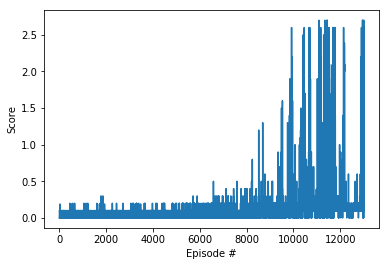

In [17]:
from agents.ppo import PPO
from agents.model import Gaussian
import random
import torch.nn.functional as F
from tensorboardX import SummaryWriter

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

seed = 257
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

logger = SummaryWriter(log_dir="./logs")

network = Gaussian(state_size, action_size, (state_size + action_size)*2 , activation = F.leaky_relu).to(device)
agent = PPO(network, device, logger,
                 LR=3e-4,
                 WEIGHT_DECAY=1e-4,
                 GRADIENT_CLIP=5, 
                 EPOCHS=3, 
                 BATCH_SIZE=256,
                GAMMA=0.99,
                GAE_TAU=0.99,
                CLIP_EPSILON=0.1,
                C1=0.5,
                C2=0.01)
scores = train(agent, logger, n_episodes=60000, train_mode=True)
plot_result(scores)
logger.close()

## View the trained agent

In [ ]:
from agents.ppo import PPO
from agents.model import Gaussian
import torch.nn.functional as F

from tensorboardX import SummaryWriter
device = "cpu"
logger = SummaryWriter(log_dir="./logs")
network = Gaussian(state_size, action_size, (state_size + action_size)*2 , activation = F.leaky_relu).to(device)
agent = PPO(network, device, logger)
agent.load("./final_weights/final_ppo.pth")
env_info = env.reset(train_mode=False)[brain_name]
for i in range(5):
    while True:
        actions, _ = agent.act(states)
        env_info = env.step(np.clip(actions, -1, 1))[brain_name]  # send all actions to the environment
        states = env_info.vector_observations                     # get next state (for each agent)
        dones = env_info.local_done                               # see if episode finished
        if np.any(dones):                                         # exit loop if episode finished
            break

I:\MyDev\Anaconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
